# Visualization

In [1]:
import numpy as np
import time
import datetime 
import json
from tqdm import tqdm
import os
import tensorflow as tf
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()

from data_utils_LMR import prepare_data,read_data, EncoderDecoder
from model import Vrae as Vrae_model
from batch import Generator

training_dir = 'logs/'
#training_dir += 'state1024_layers2_latent16_batch256_LSTM_seqs15-30_8e-3'
#training_dir += 'state1024_layers2_latent16_batch256_LSTM_seqs15-30_8e-3_d0.5'
#training_dir += state300_layers5_latent16_batch256_LSTM_seqs15-30_8e-3_B0.01_f32
#training_dir += '6layers_UGRNN_small'
#training_dir += '4layers_UGRNN'
training_dir += '2layers_LSTM'

# sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyzer = SentimentIntensityAnalyzer()
def getSentimentScore(sentence):
    scores = sentimentAnalyzer.polarity_scores(sentence)
    return (scores['neg'], scores['neu'] ,scores['pos'])

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
with open(training_dir +'/flags.json', 'r') as fp:
    FLAGS = dotdict(json.loads( fp.read() ) )
    
for k,v in FLAGS.iteritems():
    print k,':',v
      
n_samples = 5000#int(FLAGS.batch_size)

Loading BokehJS ...

sequence_max : 30
beta_period : 10
training_dir : logs/2layers_LSTM
batch_size : 128
num_layers : 2
initialize : False
teacher_forcing : True
learning_rate_change_rate : 3000
sequence_min : 8
latent_dim : 16
dtype_precision : 32
state_size : 1024
cell : LSTM
initial_learning_rate : 0.0008
epoches : 10000
output_keep_prob : 0.5
acceptable_accuracy : 0.4
input_keep_prob : 0.9
latent_loss_weight : 0.01


/home/ubuntu/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Prepare data

Data already downloaded.
Creating Vocabulary..
Vocabulary already created.
Converting sentences to sequences of ids..
  reading data line 10000
  reading data line 20000
  reading data line 30000
34758  sentences


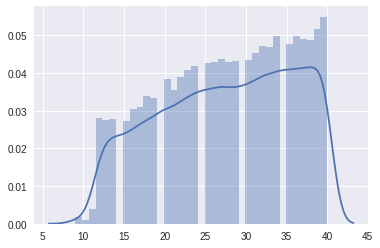

In [13]:
with open(training_dir +'/training_parameters.json', 'r') as fp:
    training_parameters = json.loads( fp.read() )
# vocabulary encoder-decoder
encoderDecoder = EncoderDecoder()
num_symbols = encoderDecoder.vocabularySize()
# prepare data
prepare_data(1000)
sentences, ratings = read_data( max_size=None, max_sentence_size=training_parameters['seq_max'],min_sentence_size=int(FLAGS.sequence_min), test=True) 
print len(sentences), " sentences"
sns.distplot( [len(sent) for sent in sentences])
plt.show()

## Loading models

In [14]:
batch_gen = Generator(sentences, ratings, n_samples )
num_iters = FLAGS.epoches * batch_gen.iterations_per_epoch()
# text decoder ( text <-> ids)
encoderDecoder = EncoderDecoder()

config = tf.ConfigProto(
        device_count = {'GPU': 1}, # do not use GPU for testing
    )

FLAGS.peephole = False
# load model
vrae_model = Vrae_model(state_size=int(FLAGS.state_size),
                         num_layers=int(FLAGS.num_layers),
                          latent_dim=int(FLAGS.latent_dim),
                         batch_size=n_samples,
                         num_symbols=num_symbols,
                        latent_loss_weight=float(FLAGS.latent_loss_weight),
                         dtype_precision=FLAGS.dtype_precision,
                        cell_type=FLAGS.cell, 
                        peephole=FLAGS.peephole,
                        input_keep_prob=float(FLAGS.input_keep_prob),
                        output_keep_prob=float(FLAGS.output_keep_prob)
                       )

def zToXdecoded(session,z_sample,s_length):
    x_reconstruct = vrae_model.zToX(session,z_sample,s_length)
    return encoderDecoder.prettyDecode( np.argmax(x_reconstruct[0], axis= 1) ) 

## Generating test data

In [15]:
saver = tf.train.Saver()
#print train_dir
samples = []
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    padded_batch_xs, batch_ratings, batch_lengths, batch_weights, max_length = batch_gen.next_batch()
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val, losses  = vrae_model.reconstruct( sess, padded_batch_xs,batch_lengths, batch_weights)
print "Done!"    

INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp

Done!


In [28]:
print losses

7.63625


In [17]:
vaderSentiments = [ getSentimentScore(encoderDecoder.prettyDecode(padded_batch_xs[i])) for i in xrange(n_samples)]

## Reconstruction

In [29]:
#np.random.seed(13)
for i in range(10):
    i = int(np.random.random()*n_samples)
    i = i
    print "sentiment:", vaderSentiments[i],"| rating:", batch_ratings[i]
    print encoderDecoder.prettyDecode( padded_batch_xs[i] )
    print encoderDecoder.prettyDecode( np.argmax(x_reconstruct[i], axis= 1) )
    print "------------------------------------------"

sentiment: (0.0, 1.0, 0.0) | rating: 4
 out of 0
 out of 0                              
------------------------------------------
sentiment: (0.0, 1.0, 0.0) | rating: 1
because he's black?
because he's abcute!
------------------------------------------
sentiment: (0.512, 0.488, 0.0) | rating: 2
what does childhood abuse mean?
what doos me ioo  ou mesa doie?
------------------------------------------
sentiment: (0.0, 0.0, 1.0) | rating: 2
entertainment?
entertaining?
------------------------------------------
sentiment: (0.0, 1.0, 0.0) | rating: 3
so far, that goal hasn't been achieved.
so does salman what a prented this it?
------------------------------------------
sentiment: (0.0, 1.0, 0.0) | rating: 3
i think it isn't.
i think it s i.
------------------------------------------
sentiment: (0.0, 1.0, 0.0) | rating: 1
kinda dark and mysterious.
kane acrin ereev  ael had!
------------------------------------------
sentiment: (0.0, 0.6, 0.4) | rating: 3
this one was alright.
this one w

## Reconstruction in the Latent Space

In [19]:
# dimension reduction
from sklearn.manifold import TSNE
X = np.array(z_vals)
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
zs_reduced = model.fit_transform(X) 
xs = [ zs_reduced[i,0] for i in xrange(n_samples) ]
ys = [ zs_reduced[i,1] for i in xrange(n_samples) ]

In [20]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Select
from bokeh.plotting import figure, output_file, show
!export BOKEH_LOG_LEVEL=error
output_file("latent_space.html")

inputs = [encoderDecoder.prettyDecode(x) for x in padded_batch_xs]
M =max(batch_lengths)
binary_rating = [ 1 if r > 5 else 0 for r in batch_ratings]
colors_sent = [ "#%02x%02x%02x" % ( 100 + 150 * r[0] ,  100 + 150 * r[2]  , 100 + 100 * r[1]  ) for r in vaderSentiments ]
color_rating = [ "#%02x%02x%02x" % (255 * (1-r) , 100, 255*r) for r in binary_rating ]
colors_lengths = [ "#%02x%02x%02x" % (  ( 255 * (float(r)/float(M))), 50, 255 - 255 * (float(r)/float(M)))  for r in batch_lengths ]
hasQuestionMark = [ int("?" in x) for x in inputs]
colors_questionMark = ["#%02x%02x%02x" % (255 * (1-r) , 100, 255*r) for r in hasQuestionMark]

source = ColumnDataSource(
        data=dict(
            x=xs,
            y=ys,
            input=inputs,
            output= [encoderDecoder.prettyDecode(np.argmax(y, axis= 1) ) for y in x_reconstruct],
            rating=batch_ratings,
            sent= vaderSentiments,
            rating_color=color_rating,
            sentiment_color=colors_sent,
            lenght_color=colors_lengths,
            questionMark_color=colors_questionMark,
            lengths=batch_lengths,
        )
    )


hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("input", "@input"),
            ("output", "@output"),
            ("rating", "@rating"),
            ("lengths", "@lengths"),
        ]
    )

p = figure(plot_width=800, plot_height=600, tools=[hover],title="Latent space")
cir = p.circle('x', 'y', size=9, source=source, fill_color="sentiment_color", alpha=0.8)

callback = CustomJS(args=dict(cir=cir,source=source), code="""
        var selected_color = cb_obj.value;
        selected_color = selected_color
        console.log(selected_color);
        cir.glyph.line_color.field = selected_color;
        cir.glyph.fill_color.field = selected_color;
        source.trigger("change")
    """)


select = Select(title="Color:", value="sentiment", options=["sentiment_color", "rating_color", "lenght_color", "questionMark_color"], callback=callback)


layout = column(select, p)

show(layout)

## Sentiment Distribution

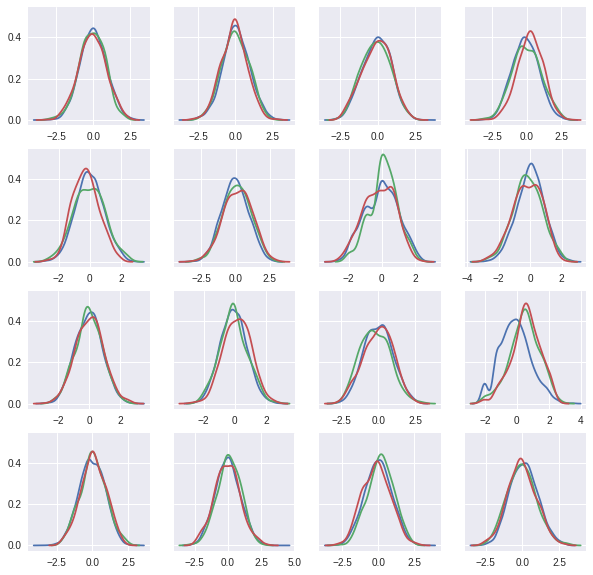

In [21]:
import seaborn as sns
cols = sns.color_palette()
pos = []
neg = []
neu = []
major_sent = np.argmax(vaderSentiments, axis = 1)
for i in xrange(n_samples):
    if major_sent[i] == 2:
        pos.append( z_mean_val[i,:] )
    elif major_sent[i] == 0:
        neg.append( z_mean_val[i,:] )
    else:
        neu.append( z_mean_val[i,:] )
        
pos = np.array(pos)
neg = np.array(neg)
neu = np.array(neu)

side_lenght = int(np.sqrt(int(FLAGS.latent_dim)))
if side_lenght**2 < int(FLAGS.latent_dim):
    side_lenght +=1
f, axs = plt.subplots(ncols=side_lenght, nrows=side_lenght, sharey=True, figsize=(10, 10))
for i in xrange(side_lenght):
    for j in xrange(side_lenght):
        k = i*side_lenght+j
        if k < int(FLAGS.latent_dim):
            sns.distplot( neu[:,k], ax=axs[i,j], hist=False, color= cols[0] )
            sns.distplot( pos[:,k], ax=axs[i,j], hist=False, color= cols[1] )
            sns.distplot( neg[:,k], ax=axs[i,j], hist=False, color= cols[2])
plt.show()

## The Sentiment Dimension

In [22]:
import scipy
import random

KLs = []
for k in xrange(int(FLAGS.latent_dim)):
    a = list(neg[:,k])
    b = list(pos[:,k])
    kl = np.abs( np.mean(a) - np.mean(b))
    
    KLs.append( kl )

for k,kl in sorted( enumerate(KLs) , key = lambda x: x[1], reverse=True ):
    print k,kl

14 0.302537
6 0.259721
3 0.246017
9 0.238963
4 0.22577
10 0.21237
13 0.142323
1 0.0990357
11 0.0877595
2 0.0629416
5 0.0588271
8 0.0480955
12 0.0225985
7 0.0191832
0 0.0125183
15 0.0101154


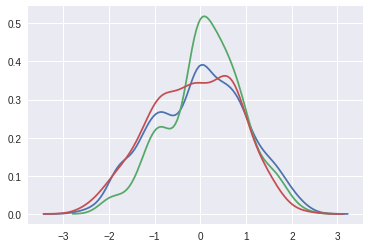

In [23]:
k=6
sns.distplot( neu[:,k], hist=False, color= cols[0] )
sns.distplot( pos[:,k], hist=False, color= cols[1] )
sns.distplot( neg[:,k], hist=False, color= cols[2])
plt.show()

In [24]:
k = 6
dx = 1.5

saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    u0 = "I like this movie."
    u1 = "I recommend this movie."
    u = u1
    print u
    z0 = vrae_model.XToz(sess, encoderDecoder.encode(u))[0]
    dz = np.zeros(int(FLAGS.latent_dim))
    dz[k] = dx
    z1 = z0 + dz
    z2 = z0 - dz
    print "distance between two points:",np.linalg.norm(z2-z1),"\n"
    zs = []
    for t in np.linspace(0,1,30):
        zs.append( (1-t) * z1 + t * z2 )

    for z_ in zs:
        print zToXdecoded(sess, z_ , 40 )

INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


I recommend this movie.
distance between two points: 3.0 

avdrride castles donen this movie made.
avdrence movies then moke  this movie.
a dreamins movie to late this movie.
a dreamiss movie to lake this movie.
a deciden something more than this one.
i decommend this movie to even oo this.
i decommend this movie to even dothing.
i decommend this movie to everyone tho.
i recommend this movie to everyone th.
i recommend this movie to everyone say.
i recommend this movie to everyone say.
i recommend this movie to everyone say.
i recommend this movie to everyone say.
i recommend this movie to everyone sho.
i recommend this movie to everyone show
i recommend this movie to everyone show
i recommend this movie to everyone sho.
i recommend this movie to everyone hho.
i recommend this movie to everyone hho.
i recommend this movie to everyone hho.
i hacommend this movie to everyone thot.
i highly recommend this movie to anyone.
i highly recommend this movie to anyone.
i highly recommend this mo

## Dimension pairplot

cross check dimensions

In [25]:
import pandas as pd 
major_sent = np.argmax(vaderSentiments, axis = 1)
sent_df = pd.DataFrame( z_mean_val )
sent_df['major_sent'] = major_sent
#sns.pairplot(sent_df, hue='major_sent', diag_kind="kde")
#plt.show()

## Continuous space: Homotopy

In [26]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    u0 = ["I loved it." , "I hated this film."]
    u01 = ["I loved it." , "It was terrible."]
    u1 = ["I loved this movie!.", "I hated this movie!"]
    u2 = ["The best movie I've seen!", "The worst movie ever made."]
    u3 = ["great movie.", "terrible movie."]
    u4 = ["that's actually pretty good." , "That was a failure."]
    u5 = ["I didn't laugh at all.", "I wanted to love this movie."]
    u6 = ["so bad that it's really bad" , "Where is the acting?"]
    u7 = ["I love old movies.", "I prefer old movies."]
    u8 = ["the music is very bad.", "the music is just awful."]
    u9 = ["awesome!", "terrible."]
    u = u0
    z1 = vrae_model.XToz(sess, encoderDecoder.encode(u[0]))[0]
    z2 = vrae_model.XToz(sess, encoderDecoder.encode(u[1]))[0]
    #z1 = np.zeros(16)
    #z2 = 0.1 * np.ones(16)
    print "distance between two points:",np.linalg.norm(z2-z1),"\n"
    zs = []
    for t in np.linspace(0,1,50):
        zs.append( (1-t) * z1 + t * z2 )

    for z_ in zs:
        print zToXdecoded(sess, z_ , 40 )

INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp



distance between two points: 4.98568 

i loved it, my wife loved it.
i loved it, my wife loved it.
i loved it, my wife loved it.
i loved it, my wife loved it.
i loved it, my wife loved it.
i loved it, my wife loved it.
i loved it, my wife loved it.
i loved the original scary movie.
i loved the original scary movie.
i loved the original scary movie.
i loved the original scary movie.
i lived the first azimi movie.
i liked the first one a let it.
i liked the filmt nig't mort ne.
i liked the film and it's best.
i liked the oolm and ives sori.
i liked the oold in g get stady.
i liked the ooigni i believe it.
i liked the ooigina swive s lot.
i liked the ooid in b d seating.
i liked the oold inse gides solit.
i liked the film and ihives iifit.
i wiled the oliver tister it to .
i will get the point of the film.
i will get the denent in of video.
i will get this one to avoid this.
i will det this doied very much on.
i willedet the poice to rece to it.
i wished she told him to stuff it.
i wishe

## Reconstruction: Reconstructing using Model's knowledge

In [27]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    u0 = "I like this movie."
    u1 = "It was terrible."
    u = u1
    z = vrae_model.XToz(sess, encoderDecoder.encode(u))[0]
    print u, "->",
    print zToXdecoded(sess,z,40)

INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


It was terrible. -> it is worse than the matrix sequels.


## Vector Translations

In [198]:
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    a = "I liked it."
    b = "I didn't like it."
    c = "I recommend this movie."
    
    
    #a = "it was terrible."
    #b = "it was not good."
    #c = "Id didn't like it."
    
    #a = "I love this movie!"
    #b = "I like this movie."
    #c = "I love the acting!"
    
    za = vrae_model.XToz(sess, encoderDecoder.encode(a))[0]
    zb = vrae_model.XToz(sess, encoderDecoder.encode(b))[0]
    zc = vrae_model.XToz(sess, encoderDecoder.encode(c))[0]
    
    # translation
    zd = zc + (zb - za)
    print "a \t\t|", a,"|", zToXdecoded(sess, za , 40 )
    print "b \t\t|", b,"|", zToXdecoded(sess, zb , 40 )
    print "c \t\t|", c,"|", zToXdecoded(sess, zc , 40 )
    print
    print "c + b-a \t|", zToXdecoded(sess, zd , 40 )

INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp



a 		| I liked it. | i liked it, i really liked it.
b 		| I didn't like it. | i didn't find it very michabloning it.
c 		| I recommend this movie. | i recommend this movie to everyone show

c + b-a 	| i did not recommend this movie this one.


## Neighborhood

In [49]:
def zToXdecoded(session,z_sample,s_length):
    x_reconstruct = vrae_model.zToX(session,z_sample,s_length)
    return encoderDecoder.prettyDecode( np.argmax(x_reconstruct[0], axis= 1) ) 


saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, "./"+training_dir+'/model.ckp')
    print
    
    # show interpolations
    u1 = "that's actually pretty good"
    u2 = ""
    u = u1
    z1 = vrae_model.XToz(sess, encoderDecoder.encode(u))[0]
    print z1
    print
    r = 1
    zs = []
    for t in range(50):
        z2 = [ z_ + r * np.random.random() for z_ in z1  ]
        zs.append( z2)

    for z_ in zs:
        print zToXdecoded(sess, z_ , 40 )

INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp


INFO:tensorflow:Restoring parameters from ./logs/2layers_LSTM/model.ckp



[-0.30519918  1.18269372 -2.62473273  1.88845623  0.19562417  0.32245705
 -1.87942851 -1.97402024 -1.5550071   0.74915385  0.45556682 -2.20178723
  0.36458147 -0.60559642  0.34466758  1.11747348]

it's a true ceality character rlally.
but that certainly nppealld at tra toll.
but that's really nct aheacher follogs.
it's that really parely suder blat.
but that ceelle as really nudelsorape.
that's actually a pretty bad film.
that's the altually that entertainmn.
that's areated realistically aptract.
that's actually a pretty dale bit .
it's that really sure led auticrli.
that's actually a pretty deseptable.
it's a true resthreacterll actunllon.
but that certainly paces really goo.
it's a true leatint cane aud crallis.
that's a serl, treaty and eeefictable.
that's actually nncementable coocce.
it's tral l theasareaced bat curtiin.
that's sctually a pretty decent siol.
that's the alterated realist carelies.
it's a truly  actuelly encellent film.
that's a tragh, pheased bu it eleline.
it's t

$$\log p(x) =  \sum_{i=1}^N q(z^{(i)} | x ) \log p(x)$$


$$ \sum_{i=1}^N q(z^{(i)} | x ) \left [    \frac{q_\phi(z^{(i)} | x) p_\theta(x,z)}{p_\theta(z|x^{(i)}) q_\phi(z^{(i)} | x) }    \right ] $$
   
   
$$ \sum_{i=1}^N q(z^{(i)} | x ) \log \frac{q(z^{(i)} | x )}{p_\theta(z|x^{(i)})} + q(z^{(i)} | x ) \log p_\theta(x,z) - q(z^{(i)} | x ) log q(z^{(i)} | x ) $$


$$ D_{KL} (q(z^{(i)} | x ) || p_\theta(z|x^{(i)})) + E_{q(z^{(i)} | x )} [- \log q(z^{(i)} | x ) + \log p_\theta (x,z)] $$

In [199]:
 & = \sum_{i=1}^N q(z^{(i)} | x ) \left [    \frac{q_\phi(z^{(i)} | x) p_\theta(x,z)}{p_\theta(z|x^{(i)}) q_\phi(z^{(i)} | x) }    \right ]  \\
    & = \sum_{i=1}^N q(z^{(i)} | x ) \log \frac{q(z^{(i)} | x )}{p_\theta(z|x^{(i)})} + q(z^{(i)} | x ) \log p_\theta(x,z) - q(z^{(i)} | x ) log q(z^{(i)} | x ) \\
    & = D_{KL} (q(z^{(i)} | x ) || p_\theta(z|x^{(i)})) + E_{q(z^{(i)} | x )} [- \log q(z^{(i)} | x ) + \log p_\theta (x,z)]

SyntaxError: invalid syntax (<ipython-input-199-5662f678ed41>, line 1)

$$ \mathcal{L} (\theta , \phi ; \theta^{(i)})  = E_{q_\phi(z| x^{(i)} )} [- \log q_\phi( | x^{(i)} ) + \log p_\theta (x^{(i)},z)] $$

$$- D_{KL} ( q_\phi(z | x^{(i)} ) || p_\theta(z) ) + E_{q_\phi(z| x^{(i)} )} [ \log p_\theta(x^{(i)} | z)]$$